# Training of a self-organizing map (SOM)

In this tutorial we present the classification procedure of PINK.

We start by loading the python-pink module:

In [1]:
import pink

print(pink.__version__)

As images we choose a set of clothing taken from [TensorFlow Keras](https://www.tensorflow.org/guide/keras).

In [2]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Show the first 25 images.

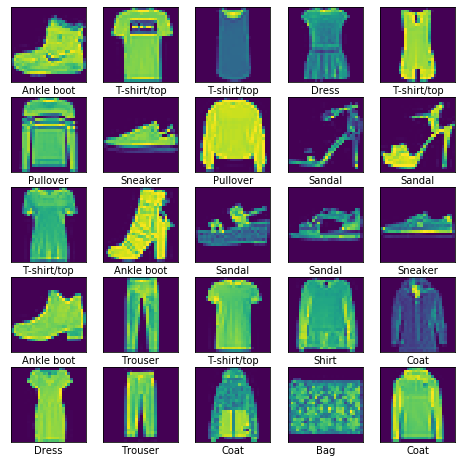

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])

The SOM is defined as a 2-dimensional rectangular layout of the dimension 10x10 containing 2-dimensional rectangular neurons of the dimension 28x28. The datatype of the pixels will by `float32`. The SOM will be initialized with random numbers.

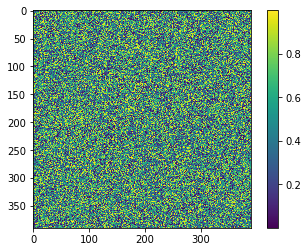

In [4]:
import math
import numpy as np

som_dim = 10
neuron_dim = int(train_images.shape[1] / math.sqrt(2.0) * 2.0)

np_som = np.random.rand(som_dim, som_dim, neuron_dim, neuron_dim).astype(np.float32)
som = pink.som(np_som)

plt.figure()
plt.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
plt.colorbar()
plt.grid(False)

As distribution function for the training propagation we choose gaussian function:

\begin{equation*}
f = \frac{\omega}{\sigma \sqrt{2 \pi}} e^{-0.5 \left(\frac{d}{\sigma}\right)^{2}}
\end{equation*}

with $\omega$ as damping factor and $d$ as distance.

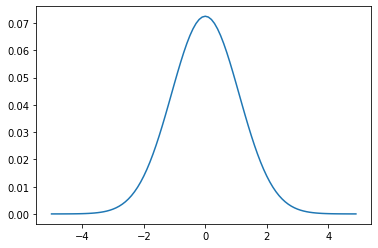

In [5]:
class GaussianFunctor():
    """ Returns the value of an gaussian distribution """

    def __init__(self, sigma=1.1, damping=0.2):
        self.sigma = sigma
        self.damping = damping

    def __call__(self, distance):
        return self.damping / (self.sigma * math.sqrt(2.0 * math.pi)) \
            * math.exp(-0.5 * math.pow((distance / self.sigma), 2))
    
x = np.arange(-5.0, 5.0, 0.1)
y = np.array([GaussianFunctor(1.1, 0.2)(i) for i in x])

plt.plot(x, y)

The trainer is defined with the distribution function and 180 rotated and flipped images.

In [6]:
trainer = pink.trainer(som, GaussianFunctor(sigma=1.1, damping=0.2),
                       number_of_rotations=180, use_flip=True)

After 1000 iterations the SOM looks sufficiently trained.

<IPython.core.display.Javascript object>


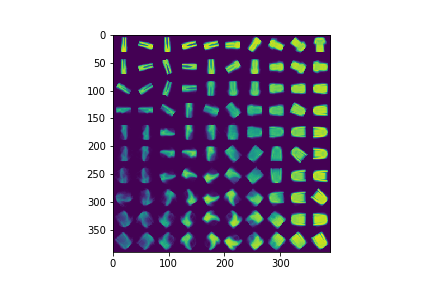

<IPython.core.display.Javascript object>


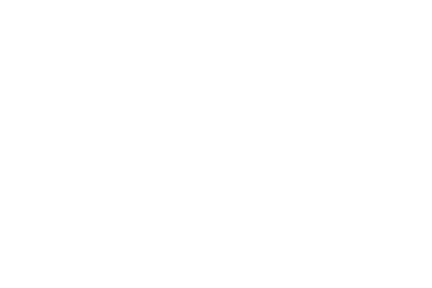

In [7]:
%matplotlib notebook
from tqdm import tqdm_notebook

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for iter in tqdm_notebook(range(5), desc="epoch"):
    for i in tqdm_notebook(range(len(train_images)), desc="train", leave=False):

        np_image = train_images[i].astype(np.float32)
        np_image /= 255

        image = pink.data(np_image)
        trainer(image)
        
        # Intermediate print
        if not i % 1000:
            trainer.update_som()
            np_som = np.array(som, copy=True)

            ax.clear()
            ax.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
            fig.canvas.draw()

# Final print
trainer.update_som()
np_som = np.array(som, copy=True)

ax.clear()
ax.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
fig.canvas.draw()